In [1]:
%cd "/content/drive/MyDrive/Desktop/PythonP/week2/Residual_networks"

/content/drive/MyDrive/Desktop/PythonP/week2/Residual_networks


In [2]:
#import all the packages
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from resnet_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

from test_utils import summary, comparator
import public_tests

%matplotlib inline

Last week, you built your first convolutional neural networks: first manually with numpy, then using Tensorflow and Keras.

In recent years, neural networks have become much deeper, with state-of-the-art networks evolving from having just a few layers (e.g., AlexNet) to over a hundred layers.

The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the shallower layers, closer to the input) to very complex features (at the deeper layers, closer to the output).

However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent prohibitively slow.

More specifically, during gradient descent, as you backpropagate from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode," from gaining very large values).

These are the individual steps:

First component of main path:

The first CONV2D has
 filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: kernel_initializer = initializer(seed=0).
The first BatchNorm is normalizing the 'channels' axis.
Then apply the ReLU activation function. This has no hyperparameters.
Second component of main path:

The second CONV2D has
 filters of shape
 and a stride of (1,1). Its padding is "same". Use 0 as the seed for the random uniform initialization: kernel_initializer = initializer(seed=0).
The second BatchNorm is normalizing the 'channels' axis.
Then apply the ReLU activation function. This has no hyperparameters.
Third component of main path:

The third CONV2D has
 filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: kernel_initializer = initializer(seed=0).
The third BatchNorm is normalizing the 'channels' axis.
Note that there is no ReLU activation function in this component.
Final step:

The X_shortcut and the output from the 3rd layer X are added together.
Hint: The syntax will look something like Add()([var1,var2])
Then apply the ReLU activation function. This has no hyperparameters.

Exercise 1 - identity_block
Implement the ResNet identity block. The first component of the main path has been implemented for you already! First, you should read these docs carefully to make sure you understand what's happening. Then, implement the rest.

To implement the Conv2D step: Conv2D
To implement BatchNorm: BatchNormalization BatchNormalization(axis = 3)(X, training = training). If training is set to False, its weights are not updated with the new examples. I.e when the model is used in prediction mode.
For the activation, use: Activation('relu')(X)
To add the value passed forward by the shortcut: Add
We have added the initializer argument to our functions. This parameter receives an initializer function like the ones included in the package tensorflow.keras.initializers or any other custom initializer. By default it will be set to random_uniform

Remember that these functions accept a seed argument that can be any value you want, but that in this notebook must set to 0 for grading purposes.



The lecture mentioned that having ResNet blocks with the shortcut also makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance.

On that note, there is also some evidence that the ease of learning an identity function accounts for ResNets' remarkable performance even more than skip connections help with vanishing gradients.

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are the same or different. You are going to implement both of them: the "identity block" and the "convolutional block."

In [3]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
  # Retrieve Filters
    F1, F2, F3 = filters
    X_shortcut = X
    cache = []
    #first component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    return X

In [4]:
np.random.seed(1)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A3 = identity_block(X, f=2, filters=[4, 4, 3],
                   initializer=lambda seed=0:constant(value=1),
                   training=False)
print('\033[1mWith training=False\033[0m\n')
A3np = A3.numpy()
print(np.around(A3.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))
resume = A3np[:,(0,-1),:,:].mean(axis = 3)
print(resume[1, 1, 0])

print('\n\033[1mWith training=True\033[0m\n')
np.random.seed(1)
A4 = identity_block(X, f=2, filters=[3, 3, 3],
                   initializer=lambda seed=0:constant(value=1),
                   training=True)
print(np.around(A4.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))

public_tests.identity_block_test(identity_block)


With training=False

[[[  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]]

 [[192.71234 192.71234 192.71234  96.85617]
  [ 96.85617  96.85617  96.85617  48.92808]]

 [[578.1371  578.1371  578.1371  290.5685 ]
  [290.5685  290.5685  290.5685  146.78426]]]
96.85617

With training=True

[[[0.      0.      0.      0.     ]
  [0.      0.      0.      0.     ]]

 [[0.40739 0.40739 0.40739 0.40739]
  [0.40739 0.40739 0.40739 0.40739]]

 [[4.99991 4.99991 4.99991 3.25948]
  [3.25948 3.25948 3.25948 2.40739]]]
All tests passed!


In [5]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
  # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X
     # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ### START CODE HERE

    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)

    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

In [6]:
from outputs import convolutional_block_output1, convolutional_block_output2
np.random.seed(1)
#X = np.random.randn(3, 4, 4, 6).astype(np.float32)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A = convolutional_block(X, f = 2, filters = [2, 4, 6], training=False)

assert type(A) == EagerTensor, "Use only tensorflow and keras functions"
assert tuple(tf.shape(A).numpy()) == (3, 2, 2, 6), "Wrong shape."
assert np.allclose(A.numpy(), convolutional_block_output1), "Wrong values when training=False."
print(A[0])

B = convolutional_block(X, f = 2, filters = [2, 4, 6], training=True)
assert np.allclose(B.numpy(), convolutional_block_output2), "Wrong values when training=True."

print('\033[92mAll tests passed!')

tf.Tensor(
[[[0.         0.66683817 0.         0.         0.88853896 0.5274254 ]
  [0.         0.65053666 0.         0.         0.89592844 0.49965227]]

 [[0.         0.6312079  0.         0.         0.8636247  0.47643146]
  [0.         0.5688321  0.         0.         0.85534114 0.41709304]]], shape=(2, 2, 6), dtype=float32)
All tests passed!


In [7]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
  X_input = Input(input_shape)
  X = ZeroPadding2D((3, 3))(X_input)
  #stage 1
  X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)
  #stage 2
  X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
  X = identity_block(X, 3, [64, 64, 256])
  X = identity_block(X, 3, [64, 64, 256])
  #stage  3
  X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
  X = identity_block(X, 3,  [128,128,512])
  X = identity_block(X, 3,  [128,128,512])
  X = identity_block(X, 3,  [128,128,512])
  #stage 4
  X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
  X = identity_block(X, 3, [256, 256, 1024])
  X = identity_block(X, 3, [256, 256, 1024])
  X = identity_block(X, 3, [256, 256, 1024])
  X = identity_block(X, 3, [256, 256, 1024])
  X = identity_block(X, 3, [256, 256, 1024])
  # stage 5
  X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
  X = identity_block(X, 3, [512, 512, 2048])
  X = identity_block(X, 3, [512, 512, 2048])
  X = AveragePooling2D((2, 2))(X)
  # output layer
  X = Flatten()(X)
  X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
  model = Model(inputs = X_input, outputs = X)
  return model

In [8]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 32, 32, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization_20 (Ba  (None, 32, 32, 64)           256       ['conv2d_20[0][0]']       

In [9]:
from outputs import ResNet50_summary

model = ResNet50(input_shape = (64, 64, 3), classes = 6)

comparator(summary(model), ResNet50_summary)

All tests passed!


In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [12]:
parameters = model.fit(X_train, Y_train, epochs = 10, batch_size = 32)
model.save('trained_resnet50.h5')



Epoch 1/10
34/34 [==============================] - 41s 95ms/step - loss: 2.0231 - accuracy: 0.4611
Epoch 2/10
34/34 [==============================] - 2s 64ms/step - loss: 0.5868 - accuracy: 0.7972
Epoch 3/10
34/34 [==============================] - 2s 56ms/step - loss: 0.4770 - accuracy: 0.8574
Epoch 4/10
34/34 [==============================] - 2s 54ms/step - loss: 0.3393 - accuracy: 0.8972
Epoch 5/10
34/34 [==============================] - 2s 54ms/step - loss: 0.4295 - accuracy: 0.8861
Epoch 6/10
34/34 [==============================] - 2s 55ms/step - loss: 0.3578 - accuracy: 0.8926
Epoch 7/10
34/34 [==============================] - 2s 54ms/step - loss: 0.4224 - accuracy: 0.8954
Epoch 8/10
34/34 [==============================] - 2s 62ms/step - loss: 0.1832 - accuracy: 0.9417
Epoch 9/10
34/34 [==============================] - 2s 64ms/step - loss: 0.1154 - accuracy: 0.9667
Epoch 10/10
34/34 [==============================] - 2s 58ms/step - loss: 0.1347 - accuracy: 0.9583


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 30ms/step - loss: 0.2169 - accuracy: 0.9500
Loss = 0.21692873537540436
Test Accuracy = 0.949999988079071


In [14]:
parameters.history

{'loss': [2.0231213569641113,
  0.5867611169815063,
  0.47699353098869324,
  0.3392636179924011,
  0.42954713106155396,
  0.3578260838985443,
  0.4223686456680298,
  0.183220773935318,
  0.11543720215559006,
  0.13474008440971375],
 'accuracy': [0.4611110985279083,
  0.7972221970558167,
  0.8574073910713196,
  0.8972222208976746,
  0.8861111402511597,
  0.8925926089286804,
  0.895370364189148,
  0.9416666626930237,
  0.9666666388511658,
  0.9583333134651184]}

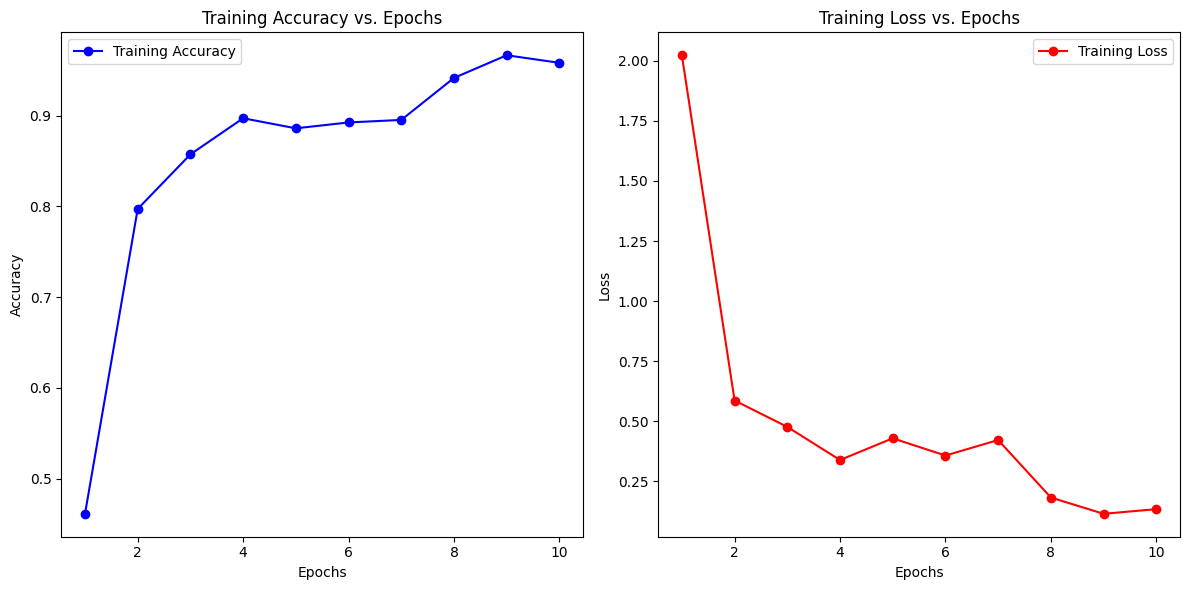

In [15]:
import matplotlib.pyplot as plt

# Assuming history is your History object returned by model.fit
epochs = range(1, len(parameters.history['accuracy']) + 1)
accuracy = parameters.history['accuracy']
loss = parameters.history['loss']

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.title('Training Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

In [64]:
# Initialize counter
correct_predictions = 0

# Assuming x_train contains your dataset
for index in range(len(X_test)):
    image = X_train[index]
    actual_class = Y_test[index]  # Use index directly for the label

    # Reshape the image to match the input shape expected by the model
    image = np.reshape(image, (1, *image.shape))

    # Make predictions
    predictions = model.predict(image)

    # Get the predicted class
    predicted_class = np.argmax(predictions)

    # Get the index where the value is 1 in the actual_class array
    actual_index = np.where(actual_class == 1)[0][0]

    # Check if the predicted class is equal to the actual class
    if predicted_class == actual_index:
        correct_predictions += 1

    # Display the image if needed

# Print the total number of correct predictions
print(f'Total correct predictions: {correct_predictions}')


1/1 [==============================] - 0s 25ms/step
Total correct predictions: 22


In [16]:
pre_trained_model = tf.keras.models.load_model('trained_resnet50.h5')


In [17]:
preds = pre_trained_model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 30ms/step - loss: 0.2169 - accuracy: 0.9500
Loss = 0.21692873537540436
Test Accuracy = 0.949999988079071


Input image shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 38ms/step
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[0.01223174 0.10411555 0.08909538 0.4068274  0.32823184 0.05949813]]
Class: 1


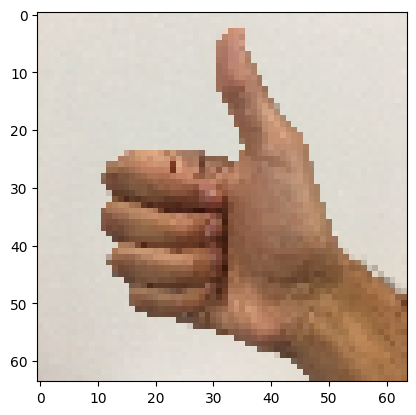

In [25]:
import math
threshold = 0.5
img_path = 'images/thumbs_up.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
imshow(img)
prediction = pre_trained_model.predict(x)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
x = np.max(prediction)
binary_prediction = math.ceil(x)
print("Class:",binary_prediction)
